In [1]:
# import libraries

import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier

In [2]:
# load datasets

churn_data = pd.read_csv('churn_data.csv')
customer_data = pd.read_csv('customer_data.csv')
internet_data = pd.read_csv('internet_data.csv')

In [3]:
churn_data.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
customer_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [5]:
internet_data.head()

,customerID,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,No,Fiber optic,No,No,No,No,No,No


In [6]:
# merge the datasets into single master data

temp_df = pd.merge(left = churn_data, right = customer_data, on = 'customerID')
telecom_data = pd.merge(left = temp_df, right = internet_data, on = 'customerID')

In [7]:
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   tenure            7043 non-null   int64  
 2   PhoneService      7043 non-null   object 
 3   Contract          7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   Churn             7043 non-null   object 
 9   gender            7043 non-null   object 
 10  SeniorCitizen     7043 non-null   int64  
 11  Partner           7043 non-null   object 
 12  Dependents        7043 non-null   object 
 13  MultipleLines     7043 non-null   object 
 14  InternetService   7043 non-null   object 
 15  OnlineSecurity    7043 non-null   object 
 16  OnlineBackup      7043 non-null   object 


In [8]:
telecom_data = telecom_data.drop(columns='customerID', axis=1)

In [9]:
# handle binary variables

binary_vars = ['PhoneService', 'PaperlessBilling', 'Churn', 'Partner', 'Dependents']
telecom_data[binary_vars] = telecom_data[binary_vars].apply(lambda x: x.map({'Yes': 1, 'No': 0}))
telecom_data.head()

,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,1,0,Month-to-month,1,Electronic check,29.85,29.85,0,Female,0,1,0,No phone service,DSL,No,Yes,No,No,No,No
1,34,1,One year,0,Mailed check,56.95,1889.5,0,Male,0,0,0,No,DSL,Yes,No,Yes,No,No,No
2,2,1,Month-to-month,1,Mailed check,53.85,108.15,1,Male,0,0,0,No,DSL,Yes,Yes,No,No,No,No
3,45,0,One year,0,Bank transfer (automatic),42.30,1840.75,0,Male,0,0,0,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,2,1,Month-to-month,1,Electronic check,70.70,151.65,1,Female,0,0,0,No,Fiber optic,No,No,No,No,No,No


In [10]:
# handling categorical variables

categorical_vars = ['Contract', 'PaymentMethod', 'gender', 'InternetService']
telecom_data = pd.get_dummies(data=telecom_data, columns=categorical_vars, dtype='int32', drop_first=True)

categorical_vars = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                    'StreamingTV', 'StreamingMovies']
telecom_data = pd.get_dummies(data = telecom_data, columns = categorical_vars, dtype='int32')

In [11]:
# remove redundant variables
redundant_vars = []

for s in categorical_vars:
    if s == 'MultipleLines':
        s += '_No phone service'
    else: s += '_No internet service'
    redundant_vars.append(s)
    
telecom_data = telecom_data.drop(columns=redundant_vars, axis = 1)

In [12]:
# change data type of total charges
telecom_data['TotalCharges'] = pd.to_numeric(telecom_data['TotalCharges'], errors='coerce')

In [13]:
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   tenure                                 7043 non-null   int64  
 1   PhoneService                           7043 non-null   int64  
 2   PaperlessBilling                       7043 non-null   int64  
 3   MonthlyCharges                         7043 non-null   float64
 4   TotalCharges                           7032 non-null   float64
 5   Churn                                  7043 non-null   int64  
 6   SeniorCitizen                          7043 non-null   int64  
 7   Partner                                7043 non-null   int64  
 8   Dependents                             7043 non-null   int64  
 9   Contract_One year                      7043 non-null   int32  
 10  Contract_Two year                      7043 non-null   int32  
 11  Paym

In [14]:
# check missing values

telecom_data.isnull().mean()*100

tenure                                   0.000000
PhoneService                             0.000000
PaperlessBilling                         0.000000
MonthlyCharges                           0.000000
TotalCharges                             0.156183
Churn                                    0.000000
SeniorCitizen                            0.000000
Partner                                  0.000000
Dependents                               0.000000
Contract_One year                        0.000000
Contract_Two year                        0.000000
PaymentMethod_Credit card (automatic)    0.000000
PaymentMethod_Electronic check           0.000000
PaymentMethod_Mailed check               0.000000
gender_Male                              0.000000
InternetService_Fiber optic              0.000000
InternetService_No                       0.000000
MultipleLines_No                         0.000000
MultipleLines_Yes                        0.000000
OnlineSecurity_No                        0.000000


In [15]:
# drop missing values of TotalCharges

telecom_data = telecom_data[~telecom_data['TotalCharges'].isnull()]

In [16]:
# check missing values

telecom_data.isnull().mean()*100

tenure                                   0.0
PhoneService                             0.0
PaperlessBilling                         0.0
MonthlyCharges                           0.0
TotalCharges                             0.0
Churn                                    0.0
SeniorCitizen                            0.0
Partner                                  0.0
Dependents                               0.0
Contract_One year                        0.0
Contract_Two year                        0.0
PaymentMethod_Credit card (automatic)    0.0
PaymentMethod_Electronic check           0.0
PaymentMethod_Mailed check               0.0
gender_Male                              0.0
InternetService_Fiber optic              0.0
InternetService_No                       0.0
MultipleLines_No                         0.0
MultipleLines_Yes                        0.0
OnlineSecurity_No                        0.0
OnlineSecurity_Yes                       0.0
OnlineBackup_No                          0.0
OnlineBack

In [17]:
# split data into train and test

train_data, test_data = train_test_split(telecom_data, train_size=0.7, test_size=0.3, random_state=100)
train_data.shape, test_data.shape

((4922, 31), (2110, 31))

In [18]:
X_train = train_data.drop(columns='Churn', axis=1)
y_train = train_data['Churn']

X_test = test_data.drop(columns='Churn', axis=1)
y_test = test_data['Churn']

### Classification using decision tree

In [19]:
dt_base = DecisionTreeClassifier(min_samples_leaf=30, max_depth=8)
dt_base.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=30)

In [20]:
y_train_pred = dt_base.predict(X_train)

In [21]:
y_test_pred = dt_base.predict(X_test)

In [22]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      3635
           1       0.70      0.54      0.61      1287

    accuracy                           0.82      4922
   macro avg       0.77      0.73      0.74      4922
weighted avg       0.81      0.82      0.81      4922



In [23]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1528
           1       0.67      0.52      0.59       582

    accuracy                           0.80      2110
   macro avg       0.75      0.71      0.73      2110
weighted avg       0.79      0.80      0.79      2110



In [24]:
fpr, tpr, _ = roc_curve(y_train, y_train_pred, drop_intermediate=False)

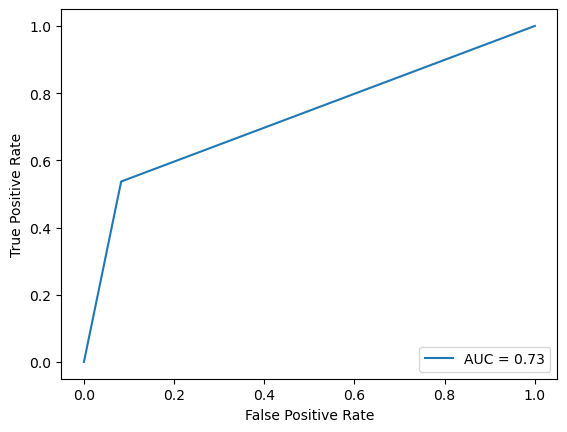

In [25]:
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_score(y_train, y_train_pred))
disp.plot()

In [26]:
# hyper parameter tuning

folds = KFold(n_splits=4, shuffle=True, random_state=100)
params = {
    'max_depth': [None, 5, 6, 7, 8, 9, 10],
    'min_samples_leaf': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [None, 15, 25, 35]
}

In [27]:
grid_serch_dt = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                            param_grid=params,
                            scoring='accuracy',
                            cv=folds,
                            n_jobs=-1,
                            return_train_score=True,
                            verbose=1)

In [28]:
%%time
grid_serch_dt.fit(X_train, y_train)

Fitting 4 folds for each of 168 candidates, totalling 672 fits
CPU times: total: 797 ms
Wall time: 36.7 s


GridSearchCV(cv=KFold(n_splits=4, random_state=100, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [None, 10, 20, 30, 40, 50],
                         'min_samples_split': [None, 15, 25, 35]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [29]:
dt_best = grid_serch_dt.best_estimator_
dt_best

DecisionTreeClassifier(max_depth=7, min_samples_leaf=30, min_samples_split=15,
                       random_state=42)

In [30]:
grid_serch_dt.best_score_

0.799471808893556

In [31]:
y_train_pred = dt_best.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      3635
           1       0.68      0.56      0.62      1287

    accuracy                           0.82      4922
   macro avg       0.77      0.73      0.75      4922
weighted avg       0.81      0.82      0.81      4922



In [32]:
y_test_pred = dt_best.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1528
           1       0.65      0.53      0.58       582

    accuracy                           0.79      2110
   macro avg       0.74      0.71      0.72      2110
weighted avg       0.78      0.79      0.78      2110



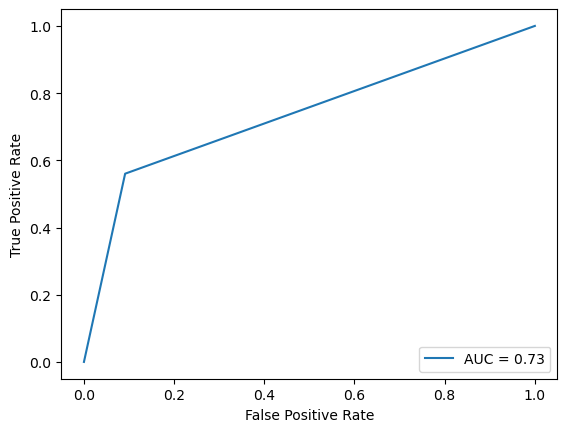

In [33]:
fpr, tpr, _ = roc_curve(y_train, y_train_pred)
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_score(y_train, y_train_pred))
disp.plot()

### Classification using random forest

In [34]:
rfc_base = RandomForestClassifier(n_estimators=10, n_jobs=-1, max_depth=7, min_samples_leaf = 30, max_features=5, random_state=42, oob_score=True)

In [35]:
rfc_base.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, max_features=5, min_samples_leaf=30,
                       n_estimators=10, n_jobs=-1, oob_score=True,
                       random_state=42)

In [36]:
rfc_base.oob_score_

0.7947988622511174

In [37]:
y_train_pred = rfc_base.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      3635
           1       0.69      0.49      0.58      1287

    accuracy                           0.81      4922
   macro avg       0.76      0.71      0.73      4922
weighted avg       0.80      0.81      0.80      4922



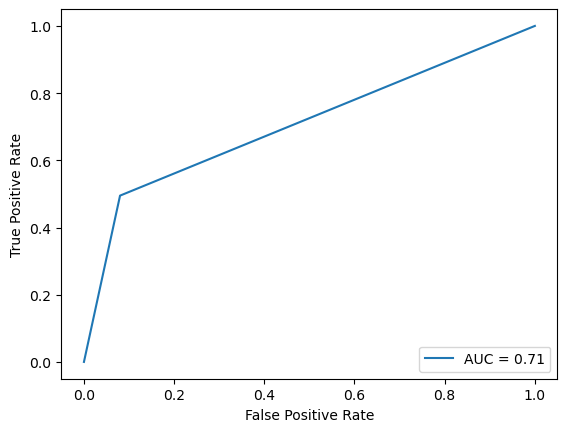

In [38]:
fpr, tpr, _ = roc_curve(y_train, y_train_pred)
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_score(y_train, y_train_pred))
disp.plot()

In [39]:
y_test = rfc_base.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1680
           1       0.77      0.86      0.81       430

    accuracy                           0.92      2110
   macro avg       0.87      0.90      0.88      2110
weighted avg       0.92      0.92      0.92      2110



In [40]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10, 25, 50, 100]
}

In [41]:
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [42]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 120 candidates, totalling 480 fits
CPU times: total: 3.16 s
Wall time: 29.6 s


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='accuracy', verbose=1)

In [43]:
grid_search.best_score_

0.8047555361824943

In [44]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_jobs=-1,
                       random_state=42)

In [45]:
y_train_pred = rf_best.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      3635
           1       0.79      0.59      0.68      1287

    accuracy                           0.85      4922
   macro avg       0.83      0.77      0.79      4922
weighted avg       0.85      0.85      0.84      4922



In [46]:
y_test_pred = rf_best.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1680
           1       0.84      0.89      0.87       430

    accuracy                           0.94      2110
   macro avg       0.91      0.93      0.92      2110
weighted avg       0.95      0.94      0.94      2110



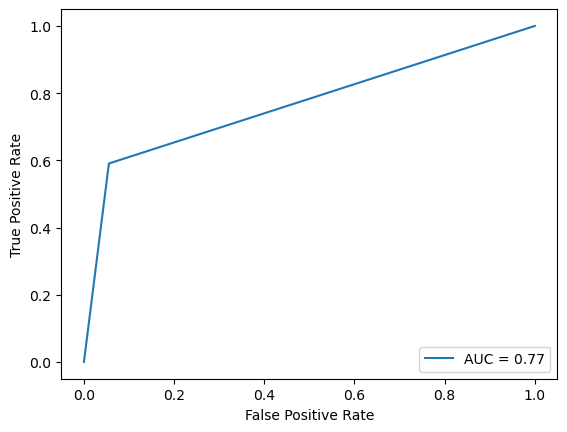

In [47]:
fpr, tpr, _ = roc_curve(y_train, y_train_pred)
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_score(y_train, y_train_pred))
disp.plot()

In [48]:
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": rf_best.feature_importances_
})

imp_df = imp_df.sort_values(by="Imp", ascending=False)

In [49]:
imp_df.head(10)

,Varname,Imp
0,tenure,0.184676
4,TotalCharges,0.139150
3,MonthlyCharges,0.104689
14,InternetService_Fiber optic,0.077149
18,OnlineSecurity_No,0.066866
24,TechSupport_No,0.061104
9,Contract_Two year,0.050092
11,PaymentMethod_Electronic check,0.041945
8,Contract_One year,0.035173
20,OnlineBackup_No,0.022137
